In [1]:
import numpy as np
from ctypes import LittleEndianStructure, Union, c_byte, c_uint16, c_int32
from matplotlib import pyplot as plt
from receive import receive

plt.rcParams["figure.figsize"] = (15,10)

# Define ctypes classes to unpack data

In [2]:
MSG_LEN = 10
GYRO_DIV = 1000.0

# TODO fix decomposing y and z values .. see https://bugs.python.org/issue29753
class Values(LittleEndianStructure):
    _pack_ = 1
    _fields_ = [
        ("ts", c_uint16, 16), 
        ("gyro_x", c_int32, 20),
        ("gyro_y", c_int32, 20),
        ("gyro_z", c_int32, 20)
    ]

class Data(Union):
    _fields_ = [("values", Values), ("raw", c_byte * MSG_LEN)]

def raw_to_values(raw):
    d = Data()
    d.raw = (c_byte*MSG_LEN)(*raw)
    
    return d.values.ts, d.values.gyro_x/GYRO_DIV, d.values.gyro_y/GYRO_DIV, d.values.gyro_z/GYRO_DIV

def read_data(filename):
    data = []
    with open(filename, "rb") as datafile:
        while parcel:=datafile.read(MSG_LEN):
            data.append(raw_to_values(parcel))
            
    return np.array(data)
    

# Temporary Workaround for unpacking

In [3]:
%%writefile unpack.c

#include <stdio.h>
#include <stdlib.h>
#include <stdbool.h>
#include <gyro_msg.h>

#define FILE_NAME_IN "out.bin"
#define FILE_NAME_OUT "out.csv"
#define MSG_SIZE sizeof(union measurement_msg)

int main() {
    FILE *fptr_in, *fptr_out;
    
    fptr_in = fopen(FILE_NAME_IN, "rb");
    fptr_out = fopen(FILE_NAME_OUT, "w");
    
    if (fptr_in == NULL || fptr_out == NULL) {
        printf("Error opening file!");
        return -1;
    }
    
    for (;;) {
        union measurement_msg msg;
        size_t n = fread(msg.raw, MSG_SIZE, 1, fptr_in);
        
        // Done :)
        if (n == 0) {
            break;
        }
        
        fprintf(fptr_out, "%u, %d, %d, %d\n", msg.values.ts, msg.values.gyro_x, msg.values.gyro_y, msg.values.gyro_z);
    }
    
    fclose(fptr_in);
    fclose(fptr_out);
    return 0;    
}

Overwriting unpack.c


In [4]:
!g++ -o unpack -I include unpack.c

In [5]:
def read_data(filename):
    tmp = np.loadtxt("out.csv", delimiter=",")
    
    tmp[:,1:] = tmp[:,1:] / GYRO_DIV
    
    return tmp

# Rest measurement processing

In [6]:
receive(5)

In [7]:
! ./unpack

In [8]:
measurements_rest = read_data("out.bin")

In [10]:
OFFSET = 20

ts, gyro_x, gyro_y, gyro_z = measurements_rest[OFFSET:,:].T

Check for jitter

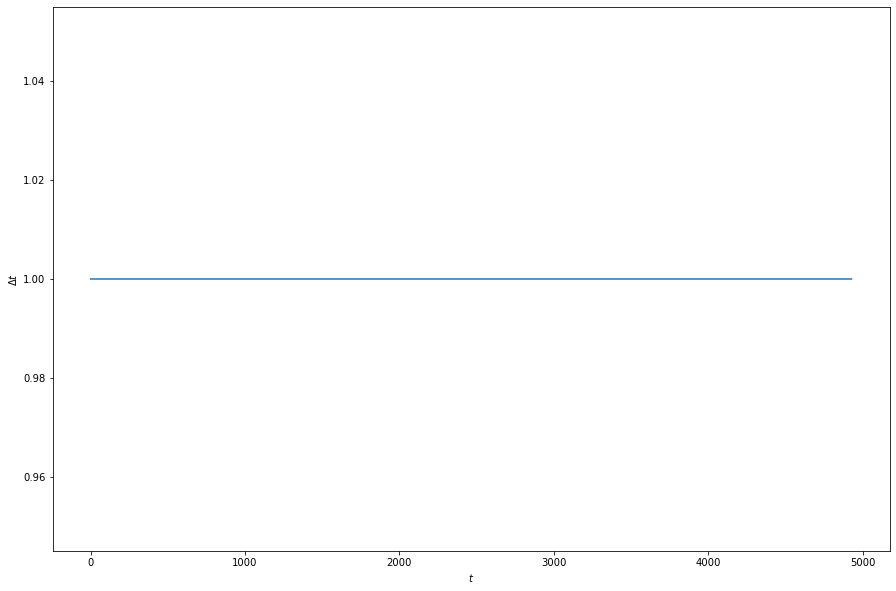

1.0

In [11]:
Δt = np.diff(ts)

plt.figure()
plt.plot(Δt)
plt.ion()
plt.xlabel("$t$")
plt.ylabel("$\Delta t$")
plt.show()

np.mean(Δt)

Check rest signal and calculate rest mean

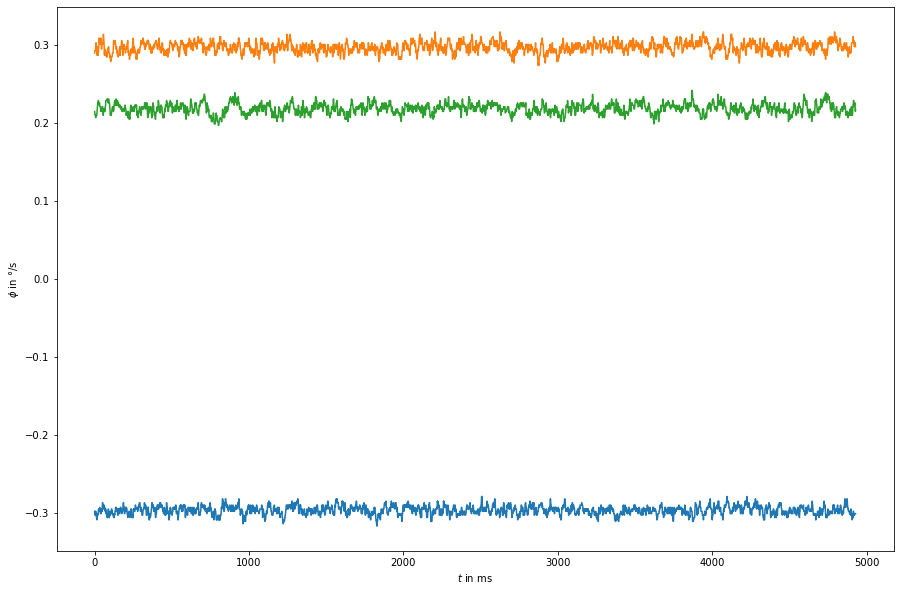

In [12]:
plt.figure()

ts_zero = ts - ts[0]

plt.plot(ts_zero, gyro_x, label="x")
plt.plot(ts_zero, gyro_y)
plt.plot(ts_zero, gyro_z)
plt.xlabel("$t$ in ms")
plt.ylabel("$\phi$ in °/s")
plt.show()

In [13]:
gyro_x_mean = np.mean(gyro_x)
gyro_y_mean = np.mean(gyro_y)
gyro_z_mean = np.mean(gyro_z)

gyro_x_mean, gyro_y_mean, gyro_z_mean

(-0.2966480016230473, 0.2971588557516737, 0.21845526475958613)

# Process movement measurements

Move the gyro around, while running next cell.

In [14]:
receive(10)

In [15]:
! ./unpack

In [16]:
measurements_movement = read_data("out.bin")
ts, gyro_x, gyro_y, gyro_z = measurements_movement[OFFSET:,:].T

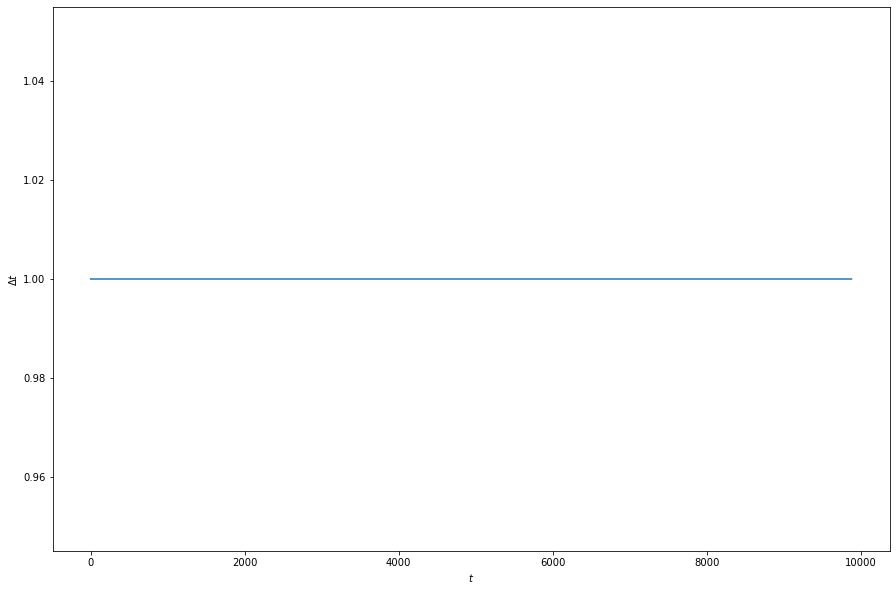

1.0

In [17]:
Δt = np.diff(ts)

plt.figure()
plt.plot(Δt)
plt.ion()
plt.xlabel("$t$")
plt.ylabel("$\Delta t$")
plt.show()

np.mean(Δt)

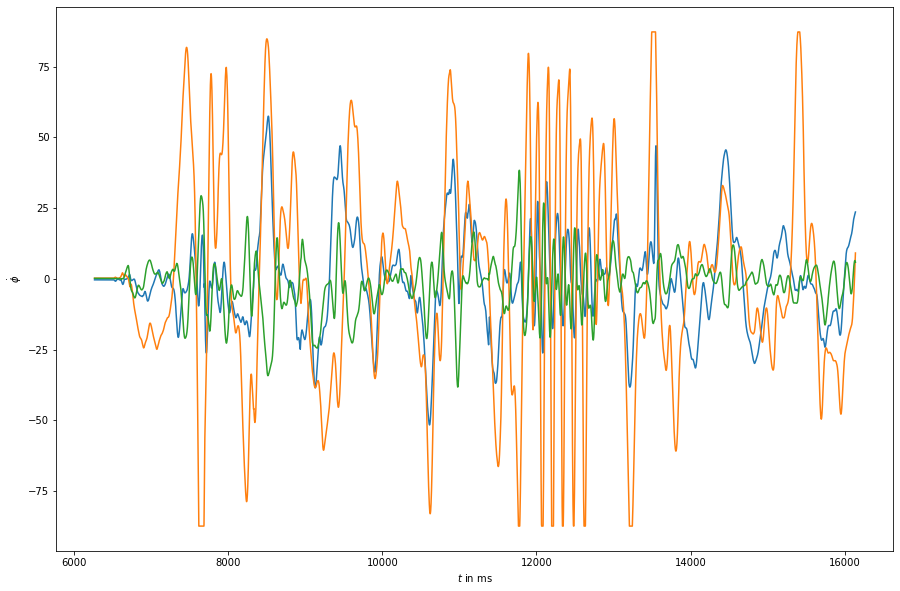

In [18]:
plt.figure(figsize=(15,10))
plt.plot(ts, gyro_x)
plt.plot(ts, gyro_y)
plt.plot(ts, gyro_z)

plt.xlabel("$t$ in ms")
plt.ylabel("$\dot{\phi}$");

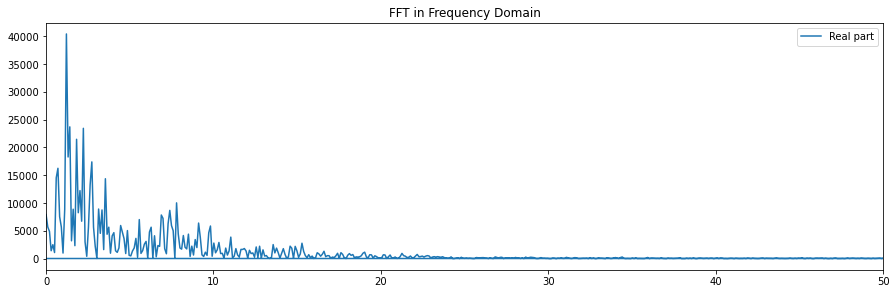

In [19]:
plt.figure
# Compute the one-dimensional discrete Fourier Transform.

fft_wave = np.fft.fft(gyro_x)

# Compute the Discrete Fourier Transform sample frequencies.

fft_fre = np.fft.fftfreq(n=gyro_x.size, d=1/1000.0)

plt.subplot(211)
plt.plot(fft_fre, np.abs(fft_wave.real), label="Real part")
plt.xlim(0, 50)
plt.legend(loc=1)
plt.title("FFT in Frequency Domain")

plt.show()

# Cleanup

In [20]:
! rm unpack.c unpack out.*